In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EqMotion import Adjoint

In [2]:
def LFR(t):
    return 0.95 - (0.95-0.15) / 150.0 * t

def alpha3(t):
    return 9.8 + (60.0 - 9.8) * t / 150.0

def alpha2(t):
    return np.sin(t * 2 * np.pi / 3.0) * np.tanh(t/150.0)

def theta(t):
    return 0.0

def d2theta(t):
    return 0.0

## **Check the forward and the backward function and eval the gradient**

In [3]:
pRef = np.array([6.0, 20.0, 40.0])
refAdj = Adjoint(nmodes=3, Np = 1)
refAdj.set_omgfunc(pRef)
t = np.linspace(0.0, 10.0, 501)
q, q_func = refAdj.forward(np.zeros(6), t, alpha2, alpha3, 0.0, LFR)

In [4]:
solver = Adjoint(nmodes=3,Np=1, t=t, y0=np.zeros(6),
                 alpha2=alpha2, alpha3=alpha3, theta=0.0, LFRt=LFR,
                 q=q, q_func=q_func)

In [11]:
p0 = np.array([5.0, 15.0, 20.0])

objVal = solver.eval_obj(p0)
objGrad = solver.eval_grad()

In [12]:
objGrad

array([-3.16325417e-03, -4.13099486e-06, -2.22325136e-06])

In [18]:
step = 1e-4
eps = np.array([1.0, 0.0, 0.0])*step
fd = (solver.eval_obj(p0+eps) - objVal) / step
print(fd)

-0.003163604955936511


## **Use gradient descent to optimize the parameters**

In [19]:
def gradient_descent(solver, p0, n_iter, alpha = 0.3, beta = 0.8, tol = 1e-6, learning_rate = 1e-3):
    '''
    Use first order optimization algorithm to find the suitable parameters for the system
    '''
    p = p0
    objVal0 = solver.eval_obj(p)
    p_history = [p0]
    obj_history = [objVal0]

    for _ in range(n_iter):
        t = 1.0
        objVal = solver.eval_obj(p)
        objGrad = solver.eval_grad()
        while solver.eval_obj(p - t * objGrad) > objVal - alpha*t*np.dot(objGrad,objGrad):
            t *= beta
        p_new = p - t * objGrad
        if np.linalg.norm(p_new - p) < tol:
            break
        p = p_new

        p_history.append(p)
        obj_history.append(solver.eval_obj(p))

    return p_history, obj_history

In [27]:
p_history, obj_history = gradient_descent(solver, p0, n_iter = 1000, alpha = 0.4)

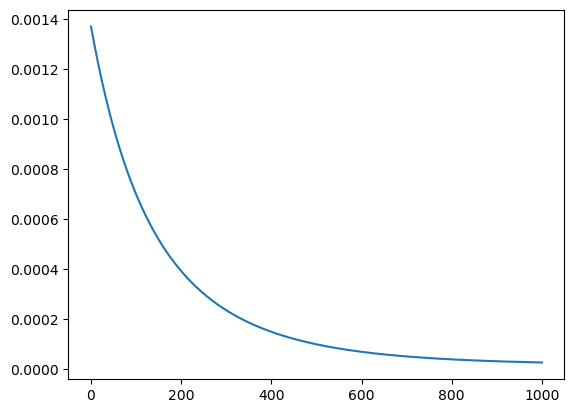

In [28]:
plt.plot(obj_history)

In [29]:
p_history = np.array(p_history)

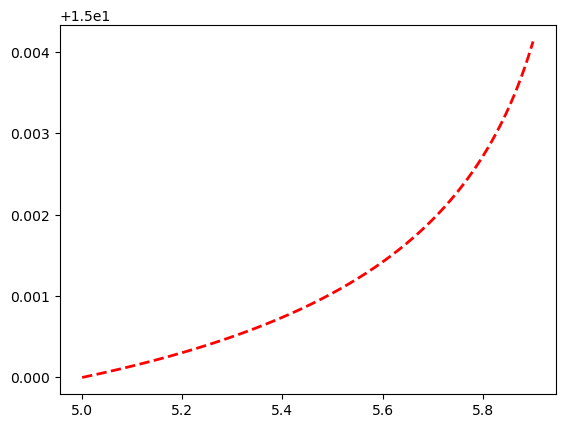

In [35]:
plt.plot(p_history[:, 0], p_history[:, 1], label = "Opt. History", ls = "dashed", lw = 2, c = "r")
# plt.scatter(pRef[0], pRef[1], marker="*")